# Cognitive Science Assignment I

| Name        | `Abhay Patil`       |
|-------------|---------------------|
| <b>Roll</b> | <b>`2020101022`</b> |

In [331]:
# general
import numpy as np
import pandas as pd
import nibabel as nib
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

# nilearn
from nilearn import datasets
from nilearn.signal import clean
from nilearn import image
from nilearn.input_data import NiftiMasker
from nilearn import plotting
from nilearn.decoding import Decoder
from nilearn.glm.first_level import FirstLevelModel

# sklearn
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneGroupOut
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter('ignore')

# The Haxby Dataset
* In the field of fMRI, one of the first studies which successfully demonstrated the feasability of brain decoding was the study by Haxby and colleagues in 2001.
* Subjects were presented with various images from different categories.
* A decoding model was used to predict the presented categories based on the brain activity responses.

In [332]:
haxby_dataset = datasets.fetch_haxby(data_dir=None, fetch_stimuli=True, verbose=False)
print("Haxby Dataset Keys:")
print(haxby_dataset.keys())

Haxby Dataset Keys:
dict_keys(['anat', 'func', 'session_target', 'mask_vt', 'mask_face', 'mask_house', 'mask_face_little', 'mask_house_little', 'mask', 'description', 'stimuli'])


## Functional and Anatomical Images

In [333]:
func = image.load_img(img=haxby_dataset["func"])
anat = image.load_img(img=haxby_dataset["anat"])

## Functional Data
* Functional data represents the activity of the brain (3D) over time (1D). Hence the data is 4D.
* We can compute the mean image of the brain over time

In [334]:
n_voxels = np.prod(func.shape[:-1])
print("func type = ", type(func))
print("func shape = ", func.shape)
print("func voxels = ", n_voxels)

func type =  <class 'nibabel.nifti1.Nifti1Image'>
func shape =  (40, 64, 64, 1452)
func voxels =  163840


func mean shape =  (40, 64, 64)


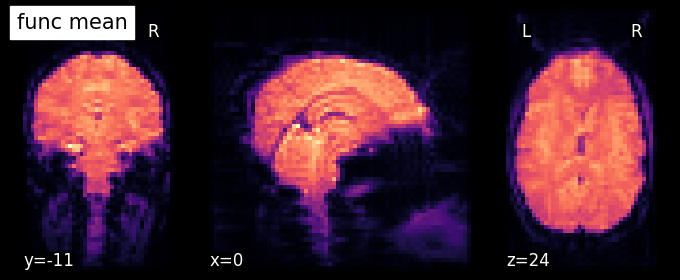

In [335]:
func_mean = image.mean_img(func)
print("func mean shape = ", func_mean.shape)
plotting.plot_epi(func_mean, title="func mean", cmap="magma", draw_cross=False)

In [336]:
X = func.get_fdata()
print("X shape = ", X.shape)
print("X type = " , type(X))

X shape =  (40, 64, 64, 1452)
X type =  <class 'numpy.ndarray'>


In [337]:
X_flat = X.reshape(n_voxels, -1).T
print("X_flat shape = ", X_flat.shape)

X_flat shape =  (1452, 163840)


## Masks
* Binary Images that are used to restrict the analysis to a specific `region of interest (ROI)`.
* Isolate relevant structures in the brain.
* Masks in the Haxby dataset include `ventral temporal`, `face`, `house`.

* `mask_vt` : The `Ventral Temporal` region is thought to be involved in recognizing objects and faces.
* `mask_face` : Binary mask that defines the regions of the brain that are involved in processing faces.
* `mask_house` : Binary mask that defines the regions of the brain that are involved in processing houses.

In [338]:
mask_vt = haxby_dataset["mask_vt"][0]
mask_face = haxby_dataset["mask_face"][0]
mask_house = haxby_dataset["mask_house"][0]

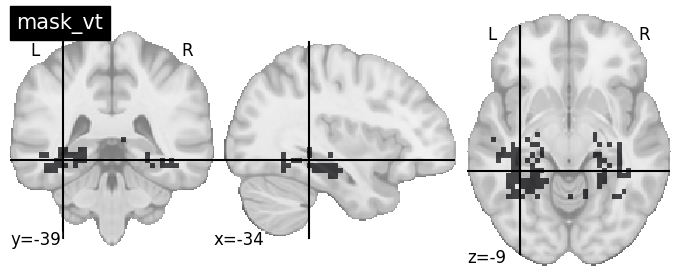

In [339]:
plotting.plot_roi(mask_vt, title="mask_vt", cmap="magma")

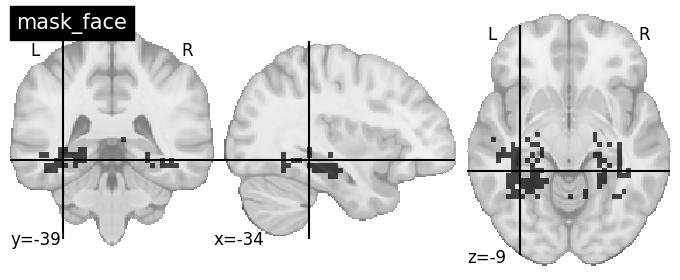

In [340]:
plotting.plot_roi(mask_vt, title="mask_face", cmap="magma")

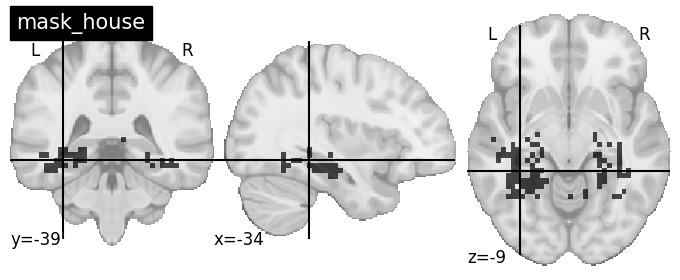

In [341]:
plotting.plot_roi(mask_vt, title="mask_house", cmap="magma")

## Stimuli

In [342]:
stimuli = pd.read_csv(haxby_dataset["session_target"][0], sep=" ")
print("stim shape = ", stimuli.shape)
stimuli.head(10)

stim shape =  (1452, 2)


,labels,chunks
0,rest,0
1,rest,0
2,rest,0
3,rest,0
4,rest,0
5,rest,0
6,scissors,0
7,scissors,0
8,scissors,0
9,scissors,0


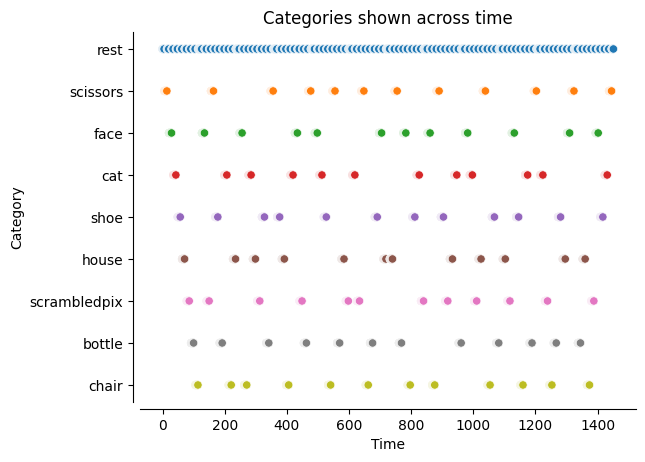

In [343]:
ax = sns.scatterplot(x=stimuli.index, y=stimuli.labels, hue=stimuli.labels, legend=False)
plt.title("Categories shown across time")
ax.set(xlabel="Time", ylabel="Category")
sns.despine(offset=5)

## Prepare the fMRI data

In [344]:
nifti_masker = NiftiMasker(mask_img=mask_vt, high_pass=0.008, standardize=True, detrend=True, smoothing_fwhm=6, t_r=2.5, mask_strategy="epi")

# data
X = nifti_masker.fit_transform(func)
y = stimuli.labels
session = stimuli.chunks

# remove the rest states
non_rest = (y != "rest")
X = X[non_rest]
y = y[non_rest]
session = session[non_rest]

# unique stimuli in order of appearance
unique_stimuli, order = np.unique(y, return_index=True)
unique_stimuli = unique_stimuli[np.argsort(order)]

In [345]:
y = y.to_numpy()

## Models

In [346]:
# supprot vector classifier: one vs one
svc_ovo = OneVsOneClassifier(Pipeline([
    ('anova', SelectKBest(f_classif, k=X.shape[-1])),
    ('svc', SVC(kernel='linear'))
]))

# support vector classifier: one vs all
svc_ova = OneVsRestClassifier(Pipeline([
    ('anova', SelectKBest(f_classif, k=X.shape[-1])),
    ('svc', SVC(kernel='linear'))
]))

In [347]:
print("X shape = ", X.shape)
print("y shape = ", y.shape)

X shape =  (864, 464)
y shape =  (864,)


In [348]:
# cross validation scores
cv_scores_ovo = cross_val_score(svc_ovo, X, y, cv=5, verbose=1)
cv_scores_ova = cross_val_score(svc_ova, X, y, cv=5, verbose=1)

print('OvO:', cv_scores_ovo.mean())
print('OvA:', cv_scores_ova.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


OvO: 0.6655464444145719
OvA: 0.631959940852265


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


Text(0.5, 1.0, 'Prediction: accuracy score')

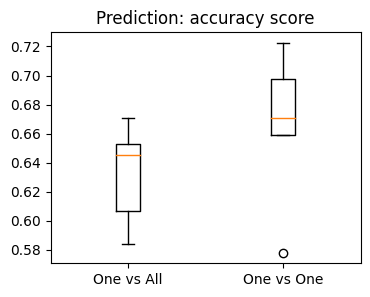

In [349]:
plt.figure(figsize=(4, 3))
plt.boxplot([cv_scores_ova, cv_scores_ovo])
plt.xticks([1, 2], ['One vs All', 'One vs One'])
plt.title('Prediction: accuracy score')

## Observation
The one vs one model performed significantly better than the one vs all model

In [350]:
masks = ['mask_vt', 'mask_face', 'mask_house']
mask_scores = {}
mask_chance_scores = {}
task_data = image.index_img(func, non_rest)
cv = LeaveOneGroupOut()

for mask in masks:
    print("Mask Type: ", mask)
    # For decoding, standardizing is often very important
    mask_file = haxby_dataset[mask][0]
    masker = NiftiMasker(mask_img=mask_file, standardize=True)
    mask_scores[mask] = {}
    mask_chance_scores[mask] = {}

    for category in unique_stimuli:
        print(f"Processing {mask} {category}")
        classification_target = (y == category)

        decoder = Decoder(estimator='svc_l1', cv=cv, mask=masker, scoring='roc_auc')
        decoder.fit(task_data, classification_target, groups=session)
        mask_scores[mask][category] = decoder.cv_scores_[1]

        # print using f-string
        print(f"Scores: {np.mean(mask_scores[mask][category]):1.2f} +- {np.std(mask_scores[mask][category]):1.2f}")

        dummy_clf = Decoder(estimator='dummy_classifier', cv=cv, mask=masker, scoring='roc_auc')
        dummy_clf.fit(task_data, classification_target, groups=session)
        mask_chance_scores[mask][category] = dummy_clf.cv_scores_[1]

Mask Type:  mask_vt
Processing mask_vt scissors
Scores: 0.92 +- 0.05
Processing mask_vt face
Scores: 0.98 +- 0.03
Processing mask_vt cat
Scores: 0.96 +- 0.04
Processing mask_vt shoe
Scores: 0.92 +- 0.07
Processing mask_vt house
Scores: 1.00 +- 0.00
Processing mask_vt scrambledpix
Scores: 0.99 +- 0.01
Processing mask_vt bottle
Scores: 0.89 +- 0.08
Processing mask_vt chair
Scores: 0.93 +- 0.04
Mask Type:  mask_face
Processing mask_face scissors
Scores: 0.70 +- 0.16
Processing mask_face face
Scores: 0.90 +- 0.06
Processing mask_face cat
Scores: 0.76 +- 0.12
Processing mask_face shoe
Scores: 0.73 +- 0.17
Processing mask_face house
Scores: 0.71 +- 0.16
Processing mask_face scrambledpix
Scores: 0.87 +- 0.09
Processing mask_face bottle
Scores: 0.67 +- 0.17
Processing mask_face chair
Scores: 0.63 +- 0.10
Mask Type:  mask_house
Processing mask_house scissors
Scores: 0.83 +- 0.08
Processing mask_house face
Scores: 0.90 +- 0.07
Processing mask_house cat
Scores: 0.86 +- 0.09
Processing mask_house 

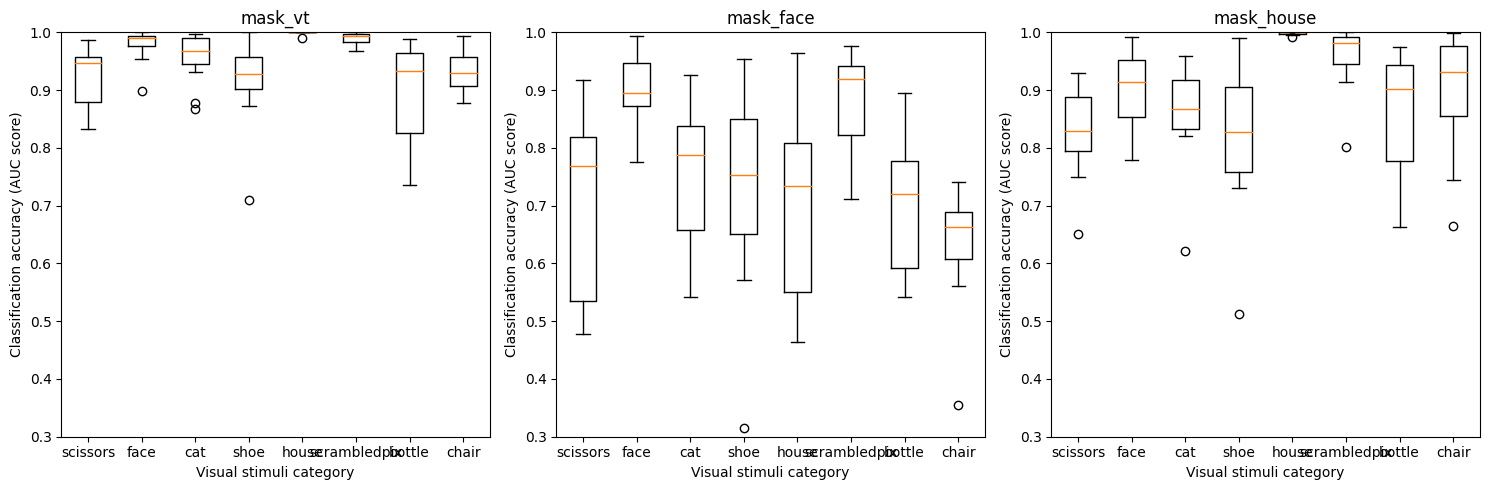

In [351]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
masks = ['mask_vt', 'mask_face', 'mask_house']

for i, mask in enumerate(masks):
    data = [mask_scores[mask][category] for category in unique_stimuli]
    labels = [f"{category}" for category in unique_stimuli]
    axs[i].boxplot(data, labels=labels)
    axs[i].set_title(mask)
    axs[i].set_ylim(0.3, 1)
    axs[i].set_ylabel('Classification accuracy (AUC score)')
    axs[i].set_xlabel('Visual stimuli category')

plt.tight_layout()
# plt.suptitle('Category-specific classification accuracy for different masks')

## NiftiMasker using ROIs

In [352]:
mask = NiftiMasker(mask_img=mask_vt, mask_strategy="epi")
func_masked_vt = mask.fit_transform(func)

print("func shape = ", func.shape)
print("func_masked_vt shape = ", func_masked_vt.shape)

func shape =  (40, 64, 64, 1452)
func_masked_vt shape =  (1452, 464)


In [353]:
func_masked_vt[0][:10]

array([366., 557., 513., 579., 340., 839., 946., 508., 872., 329.],
      dtype=float32)

Text(0.5, 1.0, 'No filtering')

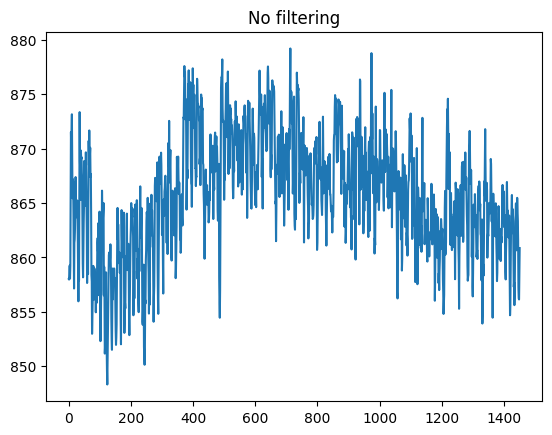

In [354]:
plt.plot(func_masked_vt.mean(axis=1))
plt.title("No filtering")

* The above plot represents the mean activation of the `ventral temporal` region of the brain. 
* The activation seems to be highest in the 400 to 1000 timestep range 

In [355]:
filters_vt = NiftiMasker(mask_img=mask_vt, high_pass=0.008, standardize=True, detrend=True, smoothing_fwhm=6.0, t_r=2.5, mask_strategy="epi")
func_masked_filtered_vt = filters_vt.fit_transform(func)

Text(0.5, 1.0, 'Filtered')

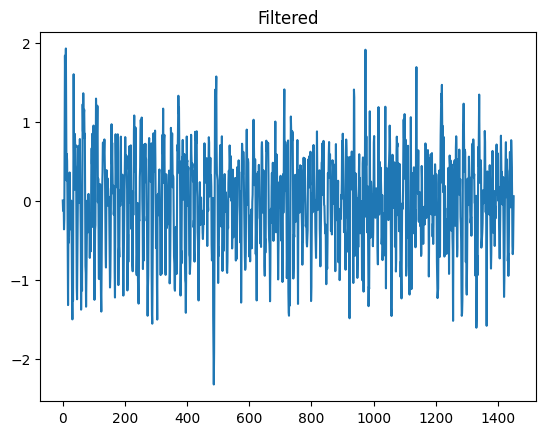

In [356]:
plt.plot(func_masked_filtered_vt.mean(axis=1))
plt.title("Filtered")

Text(0.5, 1.0, 'Zoom in to 100 time points')

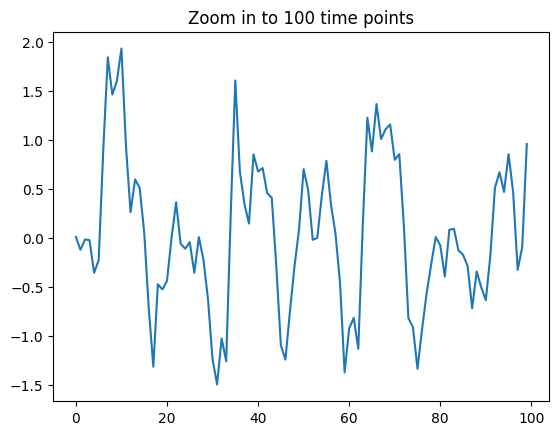

In [357]:
# zoom the mean filtered signal
# is the BOLD pheonomena block like?
plt.plot(func_masked_filtered_vt.mean(axis=1)[:100])
plt.title("Zoom in to 100 time points")

In [358]:
# Repeat NiftiMasker, filtering parameters using face mask
nifti_masker_filters_face = NiftiMasker(mask_img=mask_face, high_pass=0.008,
                                        standardize=True, detrend=True, 
                                        smoothing_fwhm=6., t_r=2.5,
                                        mask_strategy='epi')
fmri_filters_applied_face_mask = nifti_masker_filters_face.fit_transform(func)

In [359]:
# Repeat NiftiMasker, filtering parameters on house mask
nifti_masker_filters_house = NiftiMasker(mask_img=mask_house, high_pass=0.008,
                                         standardize=True, detrend=True, 
                                         smoothing_fwhm=6., t_r=2.5,
                                         mask_strategy='epi')
fmri_filters_applied_house_mask = nifti_masker_filters_house.fit_transform(func)

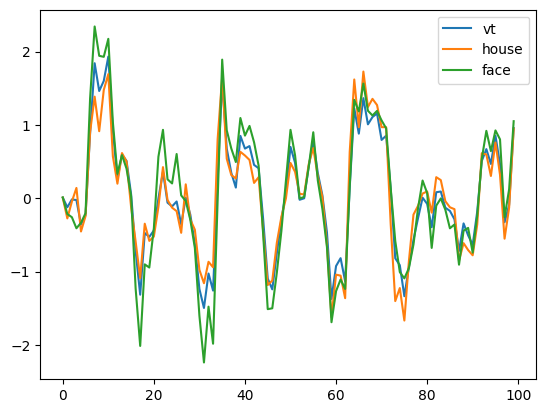

In [360]:
plt.plot(func_masked_filtered_vt.mean(axis=1)[:100])
plt.plot(fmri_filters_applied_house_mask.mean(axis=1)[:100])
plt.plot(fmri_filters_applied_face_mask.mean(axis=1)[:100])

plt.legend(['vt', 'house', 'face'])

# Beta Maps

In [361]:
TR = 2.5
glm = FirstLevelModel(
    t_r=TR,
    mask_img=haxby_dataset.mask,
    high_pass=0.008,
    smoothing_fwhm=8
)

# Number of columns corresponds to the number of regressors in the design matrix as can be seen from the above figure.
contrasts = {
    'bottle':       np.array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'cat':          np.array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'chair':        np.array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'face':         np.array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'house':        np.array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'rest':         np.array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'scissors':     np.array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
    'scrambledpix': np.array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
    'shoe':         np.array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
}

In [362]:
conditions = stimuli.labels
sessions = stimuli.chunks
unique_sessions = sessions.unique()
N_SESSIONS = len(unique_sessions)

In [363]:
conditions[:20]

0         rest
1         rest
2         rest
3         rest
4         rest
5         rest
6     scissors
7     scissors
8     scissors
9     scissors
10    scissors
11    scissors
12    scissors
13    scissors
14    scissors
15        rest
16        rest
17        rest
18        rest
19        rest
Name: labels, dtype: object

## Prepare events for all sessions

In [364]:
def get_events(session):
    conditions_session = conditions[sessions == session]
    n_scans = len(conditions_session)
    frame_times = TR * np.arange(n_scans)
    duration = TR * np.ones(n_scans)
    events = pd.DataFrame({
        'onset': frame_times,
        'trial_type': conditions_session,
        'duration': duration
    })
    return events

eventsDict = {}
for session in unique_sessions:
    eventsDict[session] = get_events(session)

In [365]:
eventsDict[0]

,onset,trial_type,duration
0,0.0,rest,2.5
1,2.5,rest,2.5
2,5.0,rest,2.5
3,7.5,rest,2.5
4,10.0,rest,2.5
...,...,...,...
116,290.0,rest,2.5
117,292.5,rest,2.5
118,295.0,rest,2.5
119,297.5,rest,2.5


In [366]:
def generate_beta_maps(sessionn, events, glm, constrasts):
    fmri_session = image.index_img(func, sessions == sessionn)
    glm.fit(fmri_session, events=events)
    # plotting.plot_design_matrix(glm.design_matrices_[0])
    box = []

    for stim in unique_stimuli:
        contrast = contrasts[stim] - contrasts['rest']
        z_map = glm.compute_contrast(contrast, output_type='z_score')
        box.append((z_map, stim))
    return box

## Generate the z maps

In [367]:
z_maps = []
conditions_label = []
each_session_label = []

for session, events in eventsDict.items():
    print("Session: ", session)
    box = generate_beta_maps(session, events, glm, contrasts)
    for it in box:
        z_maps.append(it[0])
        conditions_label.append(it[1])
        each_session_label.append(session)

Session:  0
Session:  1
Session:  2
Session:  3
Session:  4
Session:  5
Session:  6
Session:  7
Session:  8
Session:  9
Session:  10
Session:  11


In [368]:
conditions_label[:8]

['scissors', 'face', 'cat', 'shoe', 'house', 'scrambledpix', 'bottle', 'chair']

## Prepare the scores for the boxplot

In [369]:
mask_scores_face_house = {}
mask_scores = {}

for mask in masks:
    mask_file = haxby_dataset[mask][0]
    masker = NiftiMasker(mask_img=mask_file, standardize=True)
    mask_scores[mask] = {}

    for stim in unique_stimuli:
        classification_target = conditions_label
        decoder = Decoder(estimator='svc_l1', cv=5, mask=masker, scoring='roc_auc')
        decoder.fit(z_maps, classification_target, groups=each_session_label)

        mask_scores[mask][stim] = decoder.cv_scores_[stim]

In [370]:
# extract only face and house scores
for mask, scores in mask_scores.items():
    temp = {}
    for stim, score in scores.items():
        if stim != 'face' and stim != 'house':
            continue
        temp[stim] = score
    mask_scores_face_house[mask] = temp

In [371]:
mask_scores_face_house

{'mask_vt': {'face': [1.0,
   0.7142857142857143,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.7142857142857143,
   0.5714285714285714,
   1.0],
  'house': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]},
 'mask_face': {'face': [0.7142857142857143,
   1.0,
   1.0,
   0.8571428571428572,
   1.0,
   0.7142857142857143,
   0.8571428571428572,
   1.0,
   1.0,
   0.8571428571428572,
   0.2857142857142857,
   1.0],
  'house': [1.0,
   1.0,
   1.0,
   1.0,
   0.7142857142857143,
   1.0,
   0.8571428571428572,
   1.0,
   0.8571428571428572,
   1.0,
   0.8571428571428572,
   1.0]},
 'mask_house': {'face': [1.0,
   0.4285714285714286,
   0.8571428571428572,
   1.0,
   1.0,
   0.8571428571428572,
   1.0,
   0.8571428571428572,
   1.0,
   0.8571428571428572,
   1.0,
   1.0],
  'house': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}}

## Boxplot - Face vs House

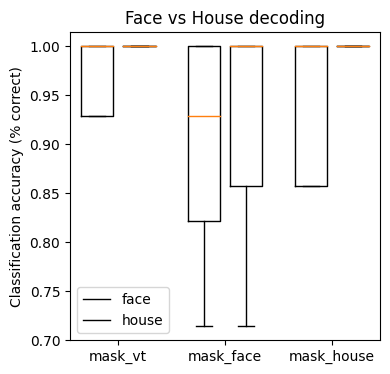

In [372]:
# make a boxplot of mask_scores_face_house
plt.figure(figsize=(4, 4))
plt.boxplot([mask_scores_face_house[mask]['face'] for mask in masks], positions=np.arange(len(masks)) * 2.0 - 0.4, sym='', widths=0.6)
plt.boxplot([mask_scores_face_house[mask]['house'] for mask in masks], positions=np.arange(len(masks)) * 2.0 + 0.4, sym='', widths=0.6)
plt.xticks(range(0, len(masks) * 2, 2), masks)
plt.ylabel('Classification accuracy (% correct)')
plt.title('Face vs House decoding')
plt.legend(['face', 'house'])
plt.show()

---
# Questions

1. What are the differences between 1 and 2 in terms of building classification model?
Discuss the trends in classification patterns, for example which of the following input i.e.,
raw timeseries or statistically derived maps makes more sense for predicting experimental
stimuli and why?

`Raw Timeseries Signals Data:`
Raw timeseries signals data (the original fMRI data) often requires preprocessing such as detrending, smoothing, band pass filtering etc. The preprocessing and noise associated with this form of input can make it difficult to work with. However, this data contains all the information about the BOLD signal, and hence we can achieve a more fine grained analysis of the fMRI data.

`Beta Maps:`
GLM analysis estimates the beta value (the amplitude of neural response) for each voxel. In a sense, this beta value is like a weight associated with a node in machine learning. Using beta maps as input results in a more compact representation of the information in the raw timeseries signals data, since it only includes information about the estimated amplitudes of the neural response. This may lead to loss of information and reduced sensitivity.

---

2. Which classification model match with the conclusions of the original paper (Haxby
et al. 2001).

The orginal paper used an `MVPA (Multi-Voxel Pattern Analysis)` for classification based on beta maps generated using the GLM analysis. The paper also supported the use of SVMs.
Hence, the second method ie the `beta maps` will match the conclusions of the original paper to a higher extent.